## Import Libraries

In [ ]:
# Generalized Autoregressive Conditional Heteroskedasticity (GARCH Model)
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
plt.rcParams['figure.figsize'] = (12,6)

## Import Data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data/ADBL_data.csv')
df['Date'] = pd.to_datetime(df.Date)
# df = df[df['Date'] >= '2015-01-01']
df.head()

,Date,Open,High,Low,Close
0,2012-01-01,115.0,115.0,113.0,114.0
1,2012-01-02,114.0,118.0,115.0,118.0
2,2012-01-03,118.0,116.0,114.0,115.0
3,2012-01-04,115.0,115.0,113.0,114.0
4,2012-01-05,114.0,114.0,112.0,113.0


## Time Series chart of ADBL

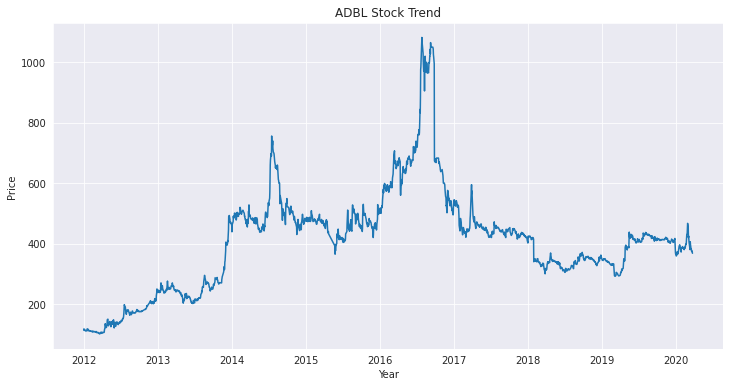

In [ ]:
plt.plot(df["Date"], df["Close"])
plt.title("ADBL Stock Trend")
plt.xlabel("Year")
plt.ylabel("Price")
plt.show()

In [ ]:
df = df[['Date', 'Close']]
df['returns'] = df.Close.pct_change().dropna() * 100
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df

,Date,Close,returns
0,2012-01-02,118.0,3.508772
1,2012-01-03,115.0,-2.542373
2,2012-01-04,114.0,-0.869565
3,2012-01-05,113.0,-0.877193
4,2012-01-08,114.0,0.884956
...,...,...,...
1905,2020-03-16,382.0,0.000000
1906,2020-03-17,378.0,-1.047120
1907,2020-03-18,374.0,-1.058201
1908,2020-03-19,376.0,0.534759


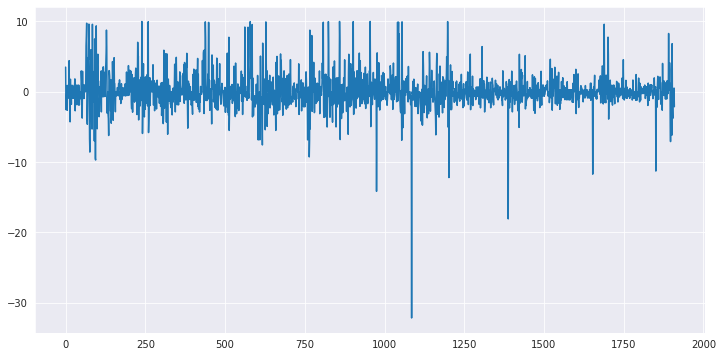

In [ ]:
df.returns.plot()
plt.show()

In [ ]:
df.returns.describe()

count    1910.000000
mean        0.094762
std         2.559813
min       -32.160804
25%        -1.018685
50%         0.000000
75%         1.010101
max        10.000000
Name: returns, dtype: float64

In [ ]:
pip install arch > /dev/null

In [ ]:
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf

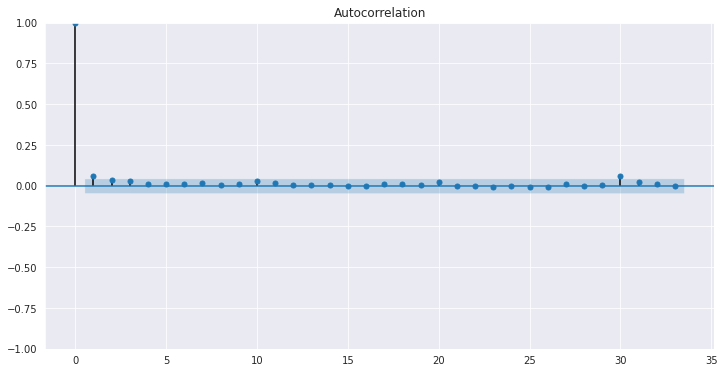

In [ ]:
# Auto correlation plot of squared stock returns
plot_acf(df.returns**2)
plt.show()

From ACF plot it can be seen there's significant positive correlation in variance out to 1 lag time steps.

## Identifying p and q terms

In [ ]:
# Optimal p and q terms based on minimal AIC
dict_aic = {}
for p in range(1, 15):
  for q in range(1, 15):
    try:
        model = arch_model(df.returns, vol='Garch', p=p, q=q)
        res = model.fit(disp='off')
        dict_aic[(p, q)] = res.aic
    except:
        pass
df_aic = pd.DataFrame.from_dict(dict_aic, orient='index', columns=['aic'])
p, q = df_aic[df_aic.aic == df_aic.aic.min()].index[0]
print(f'GARCH order is ({p}, {q})')

GARCH order is (10, 1)


## Train/Test Split

In [ ]:
# Split Train and Test set into 70/30 percent
X_train, X_test = train_test_split(df.returns, test_size=0.30, shuffle=False)
print(X_train.shape, X_test.shape)

(1337,) (573,)


## Model Training

In [ ]:
model = arch_model(X_train, vol='Garch', p=p, q=q)
model = model.fit(disp='off')
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3173.81
Distribution:                  Normal   AIC:                           6373.61
Method:            Maximum Likelihood   BIC:                           6441.19
                                        No. Observations:                 1337
Date:                Fri, Apr 01 2022   Df Residuals:                     1336
Time:                        10:35:20   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.0237  8.210e-02      0.289      0.773 [ -0.137,  0.185]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          2.5647      0.727      3.529  4.166e-04      [  1.140,  3.989]
alpha[1]       0.4440      0.132      3.353  8.001e-04      [  0.184,  0.704]
alpha[2]       0.0655  5.409e-02      1.210      0.226   [-4.057e-02,  0.171]
alpha[3]       0.0493  7.047e-02      0.700      0.484   [-8.880e-02,  0.187]
alpha[4]       0.0000  3.672e-03      0.000      1.000 [-7.198e-03,7.198e-03]
alpha[5]       0.0568  4.805e-02      1.182      0.237   [-3.738e-02,  0.151]
alpha[6]       0.0382  3.115e-02      1.226      0.220 [-2.284e-02,9.925e-02]
alpha[7]       0.0000  3.109e-03      0.000      1.000 [-6.093e-03,6.093e-03]
alpha[8]       0.0000  4.944e-03      0.000      1.000 [-9.690e-03,9.690e-03]
alpha[9]       0.0000  4.816e-03      0.000      1.000 [-9.440e-03,9.440e-03]
alpha[10]      0.2453      0.237      1.034      0.301      [ -0.220,  0.710]
beta[1]        0.0000  4.436e-02      0.000      1.000 [-8.695e-02,8.695e-02]
=============================================================================

Covariance estimator: robust
"""

## Rolling Forecast on Test set

In [ ]:
# Predicting volatility based on test set on a rolling basis
forecasts = list()
for i in range(X_test.shape[0]):
    x_test = df.returns[:-(X_test.shape[0] -i)]
    model = arch_model(x_test, p=p, q=q)
    model = model.fit(disp='off')
    forecast = model.forecast(horizon=1)
    forecasts.append(np.sqrt(forecast.variance.values[-1,:][0]))

/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


## Loss Analysis

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
# calculate root mean squared error
testScore = mean_squared_error(X_test, forecasts, squared=False)
print("Test Score: %.2f RMSE" % (testScore))

Test Score: 2.93 RMSE


In [ ]:
# Generating closing price from forecasted returns with reference to actual closing price in the last index of training set
# Todays value = yesterdays value + (pct_returns * yesterdays value) / 100
pred_vals = []
for i in range(len(forecasts)):
  if pred_vals:
    pred_val = pred_vals[i-1] + (forecasts[i] * pred_vals[i-1]) / 100
  else:
    pred_val = df.Close[X_train.shape[0]] + (forecasts[i] * df.Close[X_train.shape[0]]) / 100
  pred_vals.append(pred_val)

In [ ]:
# calculate root mean squared error of actual predicted values with reference to closing price
testScore = mean_squared_error(df.Close[X_train.shape[0]:], pred_vals, squared=False)
print("Test Score: %.2f RMSE" % (testScore))

Test Score: 12123349.65 RMSE


In [ ]:
date_range = df['Date'][-X_test.shape[0]:]

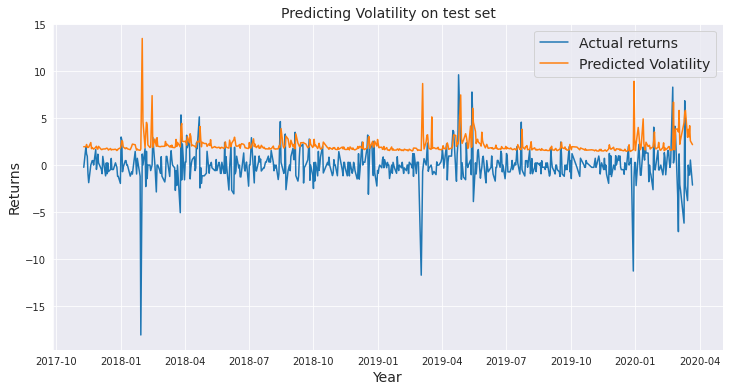

In [ ]:
plt.title('Predicting Volatility on test set', fontsize=14)
plt.plot(date_range, X_test, label='Actual returns')
plt.plot(date_range, forecasts, label='Predicted Volatility')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Returns', fontsize=14)
plt.legend(fontsize=14)
plt.show()